In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "../../Dataset/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((910577, 35), (910577, 1), (35646, 35), (35646, 1), (57419, 35), (57419, 1))

In [16]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic'])

In [12]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [18]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train), num_boost_round=500)
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    #choose the metric you want to optimized
    
    match optimisation_metric:
        case "auc":
            return auc
        case "recall":
            return recall
        case "precision":
            return precision
        case "f1":
            return f1
        case _:
            return auc
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-10-23 22:22:17,345] A new study created in memory with name: no-name-d6697f8c-e445-4102-abdb-b3e3d1bd9e08


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:22:46,461] Trial 0 finished with value: 0.9636873435293191 and parameters: {'num_leaves': 84, 'lambda_l1': 1.9743089341965159, 'lambda_l2': 0.034033622149636525, 'feature_fraction': 0.4828511932754119, 'bagging_fraction': 0.8629641279924658, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 0 with value: 0.9636873435293191.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:23:45,976] Trial 1 finished with value: 0.9698079711185993 and parameters: {'num_leaves': 217, 'lambda_l1': 0.09942980475624708, 'lambda_l2': 3.76783556651331, 'feature_fraction': 0.8947043803326273, 'bagging_fraction': 0.9878752735723937, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 1 with value: 0.9698079711185993.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:24:12,344] Trial 2 finished with value: 0.959497381360892 and parameters: {'num_leaves': 98, 'lambda_l1': 0.8884952103603068, 'lambda_l2': 2.7196243226784613e-08, 'feature_fraction': 0.4740872760125768, 'bagging_fraction': 0.6205814858228127, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 1 with value: 0.9698079711185993.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:24:58,154] Trial 3 finished with value: 0.9736193383656773 and parameters: {'num_leaves': 229, 'lambda_l1': 1.5219287153884521e-06, 'lambda_l2': 0.7593809825807439, 'feature_fraction': 0.8630633881420839, 'bagging_fraction': 0.5827415668502326, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:25:30,924] Trial 4 finished with value: 0.9621780241847064 and parameters: {'num_leaves': 255, 'lambda_l1': 8.607260723448295e-05, 'lambda_l2': 2.213362550819861e-07, 'feature_fraction': 0.44630944682662294, 'bagging_fraction': 0.4340509744690155, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:26:01,091] Trial 5 finished with value: 0.9676410982963636 and parameters: {'num_leaves': 76, 'lambda_l1': 6.996256228354022, 'lambda_l2': 5.965259999138856e-05, 'feature_fraction': 0.7328171429696885, 'bagging_fraction': 0.6906511704174683, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:26:24,332] Trial 6 finished with value: 0.9529801277509204 and parameters: {'num_leaves': 54, 'lambda_l1': 3.5691271093795926e-07, 'lambda_l2': 2.530131001159744e-06, 'feature_fraction': 0.5301786476298067, 'bagging_fraction': 0.9648956322648842, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-10-23 22:27:05,205] Trial 7 finished with value: 0.612812474589237 and parameters: {'num_leaves': 252, 'lambda_l1': 9.187318059363433e-07, 'lambda_l2': 3.761924745839708e-08, 'feature_fraction': 0.8030511906236862, 'bagging_fraction': 0.6013162194342064, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:27:27,528] Trial 8 finished with value: 0.9411461427581461 and parameters: {'num_leaves': 76, 'lambda_l1': 0.010337644081153126, 'lambda_l2': 0.00392085341600363, 'feature_fraction': 0.5143931961075968, 'bagging_fraction': 0.5799907203353427, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:28:24,704] Trial 9 finished with value: 0.9683126113347679 and parameters: {'num_leaves': 141, 'lambda_l1': 3.685128983629741e-07, 'lambda_l2': 6.4032842794727785, 'feature_fraction': 0.8736387027133272, 'bagging_fraction': 0.8817867391898959, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:29:04,910] Trial 10 finished with value: 0.9664499406078855 and parameters: {'num_leaves': 154, 'lambda_l1': 2.796648956143541e-08, 'lambda_l2': 0.09989196483393573, 'feature_fraction': 0.9883920971013213, 'bagging_fraction': 0.40813528739073, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:29:58,345] Trial 11 finished with value: 0.972819513697761 and parameters: {'num_leaves': 198, 'lambda_l1': 0.00066659139771853, 'lambda_l2': 4.834702785133855, 'feature_fraction': 0.9115721191210339, 'bagging_fraction': 0.7957866154798259, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:30:51,731] Trial 12 finished with value: 0.9684940274600847 and parameters: {'num_leaves': 190, 'lambda_l1': 0.00013274305727462973, 'lambda_l2': 0.4858364338772676, 'feature_fraction': 0.9878078117708353, 'bagging_fraction': 0.7798899301016833, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:31:36,055] Trial 13 finished with value: 0.9710693919296755 and parameters: {'num_leaves': 188, 'lambda_l1': 0.002076322273502831, 'lambda_l2': 9.65948336550868, 'feature_fraction': 0.6982560893901705, 'bagging_fraction': 0.7362800813644308, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:32:20,915] Trial 14 finished with value: 0.9668576761123647 and parameters: {'num_leaves': 209, 'lambda_l1': 1.4267703090999657e-05, 'lambda_l2': 0.003627819162357306, 'feature_fraction': 0.8910727826076857, 'bagging_fraction': 0.5132186980572093, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:32:35,686] Trial 15 finished with value: 0.9693130465240751 and parameters: {'num_leaves': 10, 'lambda_l1': 8.933809773802657e-06, 'lambda_l2': 0.2676965664858294, 'feature_fraction': 0.7958020851865456, 'bagging_fraction': 0.6675413864260584, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:33:27,217] Trial 16 finished with value: 0.9675963695370275 and parameters: {'num_leaves': 167, 'lambda_l1': 0.0007241894211022985, 'lambda_l2': 0.9542058537914695, 'feature_fraction': 0.6533345325498138, 'bagging_fraction': 0.7660020123934839, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:34:18,450] Trial 17 finished with value: 0.9662246100309448 and parameters: {'num_leaves': 231, 'lambda_l1': 0.013724397827469556, 'lambda_l2': 0.018441511428651983, 'feature_fraction': 0.9427418123008463, 'bagging_fraction': 0.5159893995726471, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:35:04,568] Trial 18 finished with value: 0.9683975319961857 and parameters: {'num_leaves': 112, 'lambda_l1': 1.4976003968081104e-08, 'lambda_l2': 0.7255171401480692, 'feature_fraction': 0.8294787631701396, 'bagging_fraction': 0.8103781244625758, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:35:55,507] Trial 19 finished with value: 0.9665812768089003 and parameters: {'num_leaves': 179, 'lambda_l1': 2.431165838287835e-05, 'lambda_l2': 0.11807636331307814, 'feature_fraction': 0.9380114305444871, 'bagging_fraction': 0.6971805342841858, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:36:45,324] Trial 20 finished with value: 0.9668230098697586 and parameters: {'num_leaves': 231, 'lambda_l1': 0.0002586881109726596, 'lambda_l2': 0.0006249917665293068, 'feature_fraction': 0.8424918326263205, 'bagging_fraction': 0.6420477186034045, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:37:45,936] Trial 21 finished with value: 0.9693788891190923 and parameters: {'num_leaves': 192, 'lambda_l1': 0.0011952042524682864, 'lambda_l2': 3.7820867610782827, 'feature_fraction': 0.732892070026641, 'bagging_fraction': 0.7425182241458317, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 3 with value: 0.9736193383656773.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:38:35,959] Trial 22 finished with value: 0.9744519680014295 and parameters: {'num_leaves': 206, 'lambda_l1': 0.003156539372625778, 'lambda_l2': 7.096464592806325, 'feature_fraction': 0.6601604464125688, 'bagging_fraction': 0.7054593817818358, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 22 with value: 0.9744519680014295.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:39:23,768] Trial 23 finished with value: 0.9751208054573507 and parameters: {'num_leaves': 214, 'lambda_l1': 0.006565280760681445, 'lambda_l2': 2.094613287916705, 'feature_fraction': 0.6178269855816465, 'bagging_fraction': 0.7009714957558588, 'bagging_freq': 3, 'min_child_samples': 99}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:40:08,808] Trial 24 finished with value: 0.9717709761885955 and parameters: {'num_leaves': 230, 'lambda_l1': 0.015749334935501128, 'lambda_l2': 0.9232784189959701, 'feature_fraction': 0.6137893731035885, 'bagging_fraction': 0.6595217402170004, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:40:46,432] Trial 25 finished with value: 0.9741282806858194 and parameters: {'num_leaves': 168, 'lambda_l1': 0.10603830282069975, 'lambda_l2': 0.10241433136556377, 'feature_fraction': 0.5879010753282549, 'bagging_fraction': 0.7249159671593745, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:41:25,867] Trial 26 finished with value: 0.9705429419937208 and parameters: {'num_leaves': 133, 'lambda_l1': 0.29680045604777966, 'lambda_l2': 0.06091487681673318, 'feature_fraction': 0.5840254387306073, 'bagging_fraction': 0.7204387314689478, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:42:01,390] Trial 27 finished with value: 0.9703682148246116 and parameters: {'num_leaves': 163, 'lambda_l1': 0.05632886040836681, 'lambda_l2': 0.2016722512884105, 'feature_fraction': 0.5729997661797929, 'bagging_fraction': 0.7026710545571795, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:42:43,609] Trial 28 finished with value: 0.9725965678791204 and parameters: {'num_leaves': 173, 'lambda_l1': 0.0031864635798763852, 'lambda_l2': 1.870717276704368, 'feature_fraction': 0.6437471345092199, 'bagging_fraction': 0.7433334912909957, 'bagging_freq': 2, 'min_child_samples': 79}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-10-23 22:43:16,035] Trial 29 finished with value: 0.9704924549155627 and parameters: {'num_leaves': 206, 'lambda_l1': 0.6999124453626755, 'lambda_l2': 0.0288882860100846, 'feature_fraction': 0.4090651604206804, 'bagging_fraction': 0.8320327770565373, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:44:04,824] Trial 30 finished with value: 0.9698885875821098 and parameters: {'num_leaves': 149, 'lambda_l1': 0.07307983932279553, 'lambda_l2': 0.26615650644294925, 'feature_fraction': 0.5667608997665174, 'bagging_fraction': 0.8618437669673866, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:44:56,467] Trial 31 finished with value: 0.9707493689987702 and parameters: {'num_leaves': 217, 'lambda_l1': 0.0048423617649409915, 'lambda_l2': 1.4088624685631805, 'feature_fraction': 0.664908583335149, 'bagging_fraction': 0.6681828349550656, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:45:38,187] Trial 32 finished with value: 0.9747165016782301 and parameters: {'num_leaves': 232, 'lambda_l1': 0.04738608561552479, 'lambda_l2': 9.817429377235388, 'feature_fraction': 0.6174042948507226, 'bagging_fraction': 0.6299514071038473, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:46:19,127] Trial 33 finished with value: 0.9731008570123353 and parameters: {'num_leaves': 244, 'lambda_l1': 0.036867523957167435, 'lambda_l2': 8.971685115751674, 'feature_fraction': 0.6086822215732701, 'bagging_fraction': 0.627135135372462, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:47:02,510] Trial 34 finished with value: 0.973198224948783 and parameters: {'num_leaves': 214, 'lambda_l1': 0.18774297011456773, 'lambda_l2': 2.1804896718997133, 'feature_fraction': 0.628935936726076, 'bagging_fraction': 0.7054184025277837, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:47:47,008] Trial 35 finished with value: 0.9690070994836242 and parameters: {'num_leaves': 239, 'lambda_l1': 0.02536649783947066, 'lambda_l2': 2.692221222886816, 'feature_fraction': 0.5494397997470524, 'bagging_fraction': 0.7589008484937694, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2023-10-23 22:48:24,211] Trial 36 finished with value: 0.9659531547385903 and parameters: {'num_leaves': 213, 'lambda_l1': 0.2122328186064799, 'lambda_l2': 0.3717335973268273, 'feature_fraction': 0.6012598271552397, 'bagging_fraction': 0.6733062586457458, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:48:56,440] Trial 37 finished with value: 0.9709085079916739 and parameters: {'num_leaves': 180, 'lambda_l1': 0.004994311563032005, 'lambda_l2': 9.525486223867887, 'feature_fraction': 0.5153271078354915, 'bagging_fraction': 0.6326379372697746, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:49:44,706] Trial 38 finished with value: 0.9658592185275015 and parameters: {'num_leaves': 120, 'lambda_l1': 2.3482316371382566, 'lambda_l2': 2.48421917560544, 'feature_fraction': 0.6803274091908956, 'bagging_fraction': 0.7207558925489902, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:50:31,588] Trial 39 finished with value: 0.9686500255518129 and parameters: {'num_leaves': 222, 'lambda_l1': 0.0905756151302628, 'lambda_l2': 0.6387132875306146, 'feature_fraction': 0.6390202024937269, 'bagging_fraction': 0.5961243997466218, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:51:16,770] Trial 40 finished with value: 0.9681252623961191 and parameters: {'num_leaves': 202, 'lambda_l1': 0.009048648242277083, 'lambda_l2': 0.058627721351953654, 'feature_fraction': 0.5410800216007072, 'bagging_fraction': 0.684740080901364, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:52:03,639] Trial 41 finished with value: 0.9718294318493661 and parameters: {'num_leaves': 247, 'lambda_l1': 0.03610400374838634, 'lambda_l2': 1.7419066999245703, 'feature_fraction': 0.7257861136399417, 'bagging_fraction': 0.5688144732899244, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:52:39,727] Trial 42 finished with value: 0.9747657091299833 and parameters: {'num_leaves': 233, 'lambda_l1': 0.001669572630009752, 'lambda_l2': 3.5456435804726185, 'feature_fraction': 0.48848836260294637, 'bagging_fraction': 0.6189332067230249, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:53:17,826] Trial 43 finished with value: 0.9705785970385491 and parameters: {'num_leaves': 255, 'lambda_l1': 0.0022215996530481636, 'lambda_l2': 4.4111587065573366, 'feature_fraction': 0.5065657633562654, 'bagging_fraction': 0.6465367434953834, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:53:57,322] Trial 44 finished with value: 0.9734429825811438 and parameters: {'num_leaves': 223, 'lambda_l1': 0.006762870480579347, 'lambda_l2': 3.5341988948304, 'feature_fraction': 0.4538900550930852, 'bagging_fraction': 0.6180358040611817, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:54:38,256] Trial 45 finished with value: 0.970597907764296 and parameters: {'num_leaves': 238, 'lambda_l1': 0.0003785406402204688, 'lambda_l2': 0.5743165530609652, 'feature_fraction': 0.4875103417815766, 'bagging_fraction': 0.6914894665920979, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:55:16,913] Trial 46 finished with value: 0.9709488743882659 and parameters: {'num_leaves': 196, 'lambda_l1': 0.016185136567211048, 'lambda_l2': 0.13127489749129242, 'feature_fraction': 0.5962775517052711, 'bagging_fraction': 0.7254988435189458, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:55:48,183] Trial 47 finished with value: 0.9716310315917657 and parameters: {'num_leaves': 155, 'lambda_l1': 0.0013106772589188925, 'lambda_l2': 9.988220952694377, 'feature_fraction': 0.5380259138991743, 'bagging_fraction': 0.6129861844060073, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:56:21,992] Trial 48 finished with value: 0.9727575099819584 and parameters: {'num_leaves': 183, 'lambda_l1': 0.003921474118176127, 'lambda_l2': 1.1597116944229027, 'feature_fraction': 0.5608950899875313, 'bagging_fraction': 0.6526149687870748, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:57:04,143] Trial 49 finished with value: 0.9690956845297471 and parameters: {'num_leaves': 206, 'lambda_l1': 0.028033908363264057, 'lambda_l2': 3.9394422993413754, 'feature_fraction': 0.6202588372973836, 'bagging_fraction': 0.7755312847677488, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:57:40,946] Trial 50 finished with value: 0.962742862912809 and parameters: {'num_leaves': 255, 'lambda_l1': 0.0995776285882863, 'lambda_l2': 0.30231652106932033, 'feature_fraction': 0.581783747472984, 'bagging_fraction': 0.5665541027085008, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:58:28,062] Trial 51 finished with value: 0.9704262051666892 and parameters: {'num_leaves': 227, 'lambda_l1': 0.0017347349848589743, 'lambda_l2': 0.9965068553711197, 'feature_fraction': 0.6769181168744702, 'bagging_fraction': 0.5922053390909902, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:59:15,465] Trial 52 finished with value: 0.9735626276500045 and parameters: {'num_leaves': 238, 'lambda_l1': 0.0004316221215666135, 'lambda_l2': 4.8474687749076875, 'feature_fraction': 0.63889194029725, 'bagging_fraction': 0.55636355973078, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 22:59:35,320] Trial 53 finished with value: 0.9677998883002479 and parameters: {'num_leaves': 42, 'lambda_l1': 0.00011669276120459193, 'lambda_l2': 0.39454118291973117, 'feature_fraction': 0.7133771083722614, 'bagging_fraction': 0.6743123017469834, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:00:16,209] Trial 54 finished with value: 0.9691675762677695 and parameters: {'num_leaves': 196, 'lambda_l1': 0.01064437960404903, 'lambda_l2': 1.766914175165508, 'feature_fraction': 0.7590263986584448, 'bagging_fraction': 0.6126170269125288, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:00:52,385] Trial 55 finished with value: 0.9696031727289744 and parameters: {'num_leaves': 220, 'lambda_l1': 0.0009382194310732823, 'lambda_l2': 0.15146906564650683, 'feature_fraction': 0.6627514371416596, 'bagging_fraction': 0.5443855904605011, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:01:32,605] Trial 56 finished with value: 0.9712246920433645 and parameters: {'num_leaves': 233, 'lambda_l1': 2.507921347045282e-06, 'lambda_l2': 5.279596958574791, 'feature_fraction': 0.697574599076154, 'bagging_fraction': 0.6479250494304691, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:02:10,956] Trial 57 finished with value: 0.9734913175603481 and parameters: {'num_leaves': 247, 'lambda_l1': 4.3281616906947924e-05, 'lambda_l2': 0.667871249829943, 'feature_fraction': 0.6204978865079468, 'bagging_fraction': 0.5857664244128037, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:02:39,628] Trial 58 finished with value: 0.9697129879404518 and parameters: {'num_leaves': 101, 'lambda_l1': 0.00023374300124441163, 'lambda_l2': 9.690978388291903, 'feature_fraction': 0.5963534902233109, 'bagging_fraction': 0.6292727238390503, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:03:18,735] Trial 59 finished with value: 0.9627257042860156 and parameters: {'num_leaves': 170, 'lambda_l1': 0.0019581328491075963, 'lambda_l2': 0.01206216057017464, 'feature_fraction': 0.5587971977623445, 'bagging_fraction': 0.7576077381470399, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:04:02,736] Trial 60 finished with value: 0.9737798151498227 and parameters: {'num_leaves': 208, 'lambda_l1': 5.060774696847719e-08, 'lambda_l2': 1.2732521383988524, 'feature_fraction': 0.6496150049313937, 'bagging_fraction': 0.7145610121661699, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:04:45,803] Trial 61 finished with value: 0.9732250389384498 and parameters: {'num_leaves': 211, 'lambda_l1': 1.4715843129625494e-07, 'lambda_l2': 1.3383011302014247, 'feature_fraction': 0.6571770539871474, 'bagging_fraction': 0.7113689718438789, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:05:27,371] Trial 62 finished with value: 0.968283819740657 and parameters: {'num_leaves': 203, 'lambda_l1': 7.843816212375778e-08, 'lambda_l2': 2.7770450632952213, 'feature_fraction': 0.6874076729854441, 'bagging_fraction': 0.679612974508902, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:06:12,553] Trial 63 finished with value: 0.9674449664673901 and parameters: {'num_leaves': 187, 'lambda_l1': 1.0276103090282016e-08, 'lambda_l2': 0.4348341231816445, 'feature_fraction': 0.6449112919725307, 'bagging_fraction': 0.7345345062249456, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:07:01,208] Trial 64 finished with value: 0.9703904919570245 and parameters: {'num_leaves': 229, 'lambda_l1': 5.473973900170588e-07, 'lambda_l2': 0.9174273700265871, 'feature_fraction': 0.6258406664746194, 'bagging_fraction': 0.7060246969351077, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:07:50,843] Trial 65 finished with value: 0.9693689429320358 and parameters: {'num_leaves': 217, 'lambda_l1': 2.7305285362382268e-08, 'lambda_l2': 0.20838819968100133, 'feature_fraction': 0.5743812396725491, 'bagging_fraction': 0.6534447991269998, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:08:31,824] Trial 66 finished with value: 0.9713687081787553 and parameters: {'num_leaves': 176, 'lambda_l1': 5.947142132805991e-06, 'lambda_l2': 5.03439614439306, 'feature_fraction': 0.666305551969174, 'bagging_fraction': 0.6862060898629272, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:09:07,303] Trial 67 finished with value: 0.971299375693543 and parameters: {'num_leaves': 137, 'lambda_l1': 0.0007639832778646346, 'lambda_l2': 0.06733054255318636, 'feature_fraction': 0.590425091731927, 'bagging_fraction': 0.7902689029665398, 'bagging_freq': 2, 'min_child_samples': 78}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:09:52,419] Trial 68 finished with value: 0.9735030668573389 and parameters: {'num_leaves': 242, 'lambda_l1': 1.8302663374704283e-07, 'lambda_l2': 2.3060854178975014, 'feature_fraction': 0.6110192307614708, 'bagging_fraction': 0.7435541534388836, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:10:32,235] Trial 69 finished with value: 0.9749004188915201 and parameters: {'num_leaves': 163, 'lambda_l1': 1.5420053351974904e-06, 'lambda_l2': 5.91628661029124, 'feature_fraction': 0.6466453766620391, 'bagging_fraction': 0.6623093281323493, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:11:11,005] Trial 70 finished with value: 0.9717734191117323 and parameters: {'num_leaves': 156, 'lambda_l1': 9.50843593586274e-07, 'lambda_l2': 6.070753483087558, 'feature_fraction': 0.6493161547835569, 'bagging_fraction': 0.6618263116178189, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:11:54,548] Trial 71 finished with value: 0.9693899404380439 and parameters: {'num_leaves': 191, 'lambda_l1': 5.145367891192776e-05, 'lambda_l2': 1.3505318501173407, 'feature_fraction': 0.6768929535460586, 'bagging_fraction': 0.6929443819754771, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:12:29,081] Trial 72 finished with value: 0.9722054093530684 and parameters: {'num_leaves': 162, 'lambda_l1': 5.727680474839586e-08, 'lambda_l2': 2.72587291123853, 'feature_fraction': 0.6327910625044902, 'bagging_fraction': 0.6301387476369641, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:13:02,138] Trial 73 finished with value: 0.9704988530475874 and parameters: {'num_leaves': 120, 'lambda_l1': 1.7336339374998655e-06, 'lambda_l2': 0.638446546511241, 'feature_fraction': 0.7006934117397182, 'bagging_fraction': 0.7176143650357439, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:13:42,244] Trial 74 finished with value: 0.9740374272110695 and parameters: {'num_leaves': 234, 'lambda_l1': 3.5469593283374806e-07, 'lambda_l2': 6.238698615899208, 'feature_fraction': 0.6072867612185784, 'bagging_fraction': 0.6060531931593693, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:14:20,074] Trial 75 finished with value: 0.9713061809794238 and parameters: {'num_leaves': 146, 'lambda_l1': 0.0037783942701850974, 'lambda_l2': 5.6789132091633014, 'feature_fraction': 0.5958127046842048, 'bagging_fraction': 0.6706306440179818, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:15:02,573] Trial 76 finished with value: 0.9669584176093347 and parameters: {'num_leaves': 222, 'lambda_l1': 0.008631425393421654, 'lambda_l2': 3.015084276307192, 'feature_fraction': 0.5784347258304595, 'bagging_fraction': 0.6039049791652762, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:15:41,994] Trial 77 finished with value: 0.9697207238637179 and parameters: {'num_leaves': 234, 'lambda_l1': 0.016801055723562667, 'lambda_l2': 6.203209888763274, 'feature_fraction': 0.6148578400774077, 'bagging_fraction': 0.6394421146923404, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:16:17,752] Trial 78 finished with value: 0.9697268893363963 and parameters: {'num_leaves': 200, 'lambda_l1': 4.3602500819432325e-07, 'lambda_l2': 1.6662481071599446, 'feature_fraction': 0.5536159130154643, 'bagging_fraction': 0.7013248036895501, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:16:56,440] Trial 79 finished with value: 0.9743844386261512 and parameters: {'num_leaves': 249, 'lambda_l1': 2.391914783409329e-07, 'lambda_l2': 8.39382623442167, 'feature_fraction': 0.6297841504126765, 'bagging_fraction': 0.6564321891815943, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:17:36,819] Trial 80 finished with value: 0.9728891370071562 and parameters: {'num_leaves': 249, 'lambda_l1': 2.247503418777837e-07, 'lambda_l2': 9.600273475976257, 'feature_fraction': 0.5299001048185839, 'bagging_fraction': 0.6614692160475661, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:18:17,488] Trial 81 finished with value: 0.9717389273636359 and parameters: {'num_leaves': 212, 'lambda_l1': 9.45633681243246e-08, 'lambda_l2': 3.5427776672449625, 'feature_fraction': 0.6344867204623065, 'bagging_fraction': 0.6815940466645898, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:18:59,853] Trial 82 finished with value: 0.9749417740903339 and parameters: {'num_leaves': 226, 'lambda_l1': 2.3176587113446647e-07, 'lambda_l2': 2.0176968974363185, 'feature_fraction': 0.6053524987435841, 'bagging_fraction': 0.6397689129838077, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:19:42,373] Trial 83 finished with value: 0.9736595884325961 and parameters: {'num_leaves': 240, 'lambda_l1': 2.9598641917692964e-07, 'lambda_l2': 6.526230183495981, 'feature_fraction': 0.6136348854547533, 'bagging_fraction': 0.6421062302999009, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:20:23,397] Trial 84 finished with value: 0.9715280798310056 and parameters: {'num_leaves': 227, 'lambda_l1': 3.378832337814435e-07, 'lambda_l2': 2.3301033138954375, 'feature_fraction': 0.6007162021803892, 'bagging_fraction': 0.6181383929492167, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:21:00,309] Trial 85 finished with value: 0.9734211126025868 and parameters: {'num_leaves': 248, 'lambda_l1': 7.489045768015926e-07, 'lambda_l2': 3.595378569391117, 'feature_fraction': 0.5738205029248978, 'bagging_fraction': 0.6033214699339144, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:21:38,068] Trial 86 finished with value: 0.9727178997282423 and parameters: {'num_leaves': 256, 'lambda_l1': 0.005935244944288994, 'lambda_l2': 0.8457849665885293, 'feature_fraction': 0.5872127941325147, 'bagging_fraction': 0.6406434517998612, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:22:16,854] Trial 87 finished with value: 0.9709464896299657 and parameters: {'num_leaves': 235, 'lambda_l1': 1.2085794551007315e-07, 'lambda_l2': 0.43188502191373074, 'feature_fraction': 0.6303067035318591, 'bagging_fraction': 0.6601075463238535, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:22:57,549] Trial 88 finished with value: 0.9721379963074634 and parameters: {'num_leaves': 225, 'lambda_l1': 0.003204216308917732, 'lambda_l2': 7.282375866548074, 'feature_fraction': 0.6651169441521185, 'bagging_fraction': 0.6223837283356162, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:23:38,832] Trial 89 finished with value: 0.973159138178596 and parameters: {'num_leaves': 218, 'lambda_l1': 0.01951495589650295, 'lambda_l2': 1.9795782141983547, 'feature_fraction': 0.6074060268161098, 'bagging_fraction': 0.6715270397058295, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:24:16,721] Trial 90 finished with value: 0.9702991149987454 and parameters: {'num_leaves': 242, 'lambda_l1': 1.8436110582484304e-07, 'lambda_l2': 3.857984390652513, 'feature_fraction': 0.5691853649545978, 'bagging_fraction': 0.5801566826797875, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:24:58,970] Trial 91 finished with value: 0.9720687801519242 and parameters: {'num_leaves': 208, 'lambda_l1': 4.1174625298459536e-08, 'lambda_l2': 1.1303612957449318, 'feature_fraction': 0.6482355285194897, 'bagging_fraction': 0.6944090503488478, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:25:42,854] Trial 92 finished with value: 0.9668835012998096 and parameters: {'num_leaves': 184, 'lambda_l1': 2.5940957011882543e-07, 'lambda_l2': 1.6435123501671762, 'feature_fraction': 0.6534120611643504, 'bagging_fraction': 0.7286759053486885, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 23 with value: 0.9751208054573507.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:26:45,355] Trial 93 finished with value: 0.975419656387738 and parameters: {'num_leaves': 196, 'lambda_l1': 7.199205108584692e-08, 'lambda_l2': 9.29309691735033, 'feature_fraction': 0.6331214357865923, 'bagging_fraction': 0.71437982476929, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:27:32,108] Trial 94 finished with value: 0.972175454462226 and parameters: {'num_leaves': 197, 'lambda_l1': 1.0577065530863303e-07, 'lambda_l2': 9.293514500207506, 'feature_fraction': 0.6270691758159275, 'bagging_fraction': 0.651914105497418, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:27:43,397] Trial 95 finished with value: 0.9698483375151912 and parameters: {'num_leaves': 4, 'lambda_l1': 5.134062169054706e-07, 'lambda_l2': 3.5997893414242874, 'feature_fraction': 0.6027937902304679, 'bagging_fraction': 0.683554700356818, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:28:21,312] Trial 96 finished with value: 0.9730069208012462 and parameters: {'num_leaves': 232, 'lambda_l1': 0.05074427034155327, 'lambda_l2': 5.772981065868785, 'feature_fraction': 0.586305031544175, 'bagging_fraction': 0.7041425728746218, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:29:00,822] Trial 97 finished with value: 0.9701221775658458 and parameters: {'num_leaves': 215, 'lambda_l1': 3.080077649646174e-08, 'lambda_l2': 6.232274797285333, 'feature_fraction': 0.6410114704576053, 'bagging_fraction': 0.6322834767272021, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:29:36,261] Trial 98 finished with value: 0.9654380469457703 and parameters: {'num_leaves': 222, 'lambda_l1': 1.350054678777226e-07, 'lambda_l2': 2.243889568755276, 'feature_fraction': 0.6181143284085292, 'bagging_fraction': 0.5913880049029887, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 93 with value: 0.975419656387738.


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


[I 2023-10-23 23:30:14,449] Trial 99 finished with value: 0.972972545382823 and parameters: {'num_leaves': 168, 'lambda_l1': 0.010667888792571429, 'lambda_l2': 0.7839343759377698, 'feature_fraction': 0.5601299284752055, 'bagging_fraction': 0.7426705072715883, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 93 with value: 0.975419656387738.


In [19]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"
best_params['num_boost_round'] = 500

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 6171, number of negative: 904406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8655
[LightGBM] [Info] Number of data points in the train set: 910577, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006777 -> initscore=-4.987417
[LightGBM] [Info] Start training from score -4.987417


In [20]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [66]:
for pred in y_pred:
    if pred > 0.5:
        print(str(pred))

0.9859614105661384
0.853315673848335
0.9005305026447933
0.6655773382210621
0.6661219603583606
0.9927532872598344
0.5718835835162356
0.7671947084413563
0.5985441135232504
0.9986396654222602
0.9847260677472983
0.9847260677472983
0.9053912791077047
0.8664800424880402
0.6149118815059738
0.5527890387470105
0.8661772196553814
0.9846477984372463
0.6258186573496543
0.9448081696224029
0.5760756175758571
0.758999682860306
0.8728082844042839
0.9755320136122735
0.9846477984372463
0.5356823438732697
0.7497580975479636
0.9306153364384838
0.5718835835162356
0.9580763568264696
0.5718835835162356
0.9488964763678299
0.78917252943417
0.6524661152530559
0.827074669247045
0.7553554969882975
0.8525584457919788
0.7867053724465456
0.8262219320178741
0.8664800424880402
0.758999682860306
0.6064458788863022
0.9759869457162625
0.8063722857271868
0.5508599395321008
0.5485688105646499
0.9369819056131319
0.9624495773591969
0.8804933865578926
0.9748036583199928
0.8963649778772644
0.8743968699691264
0.758999682860306


Accuracy: 0.995034505975425
Recall: 0.12179487179487179
Precision: 0.3220338983050847
F1 Score: 0.17674418604651163
AUC: 0.9515515385337872


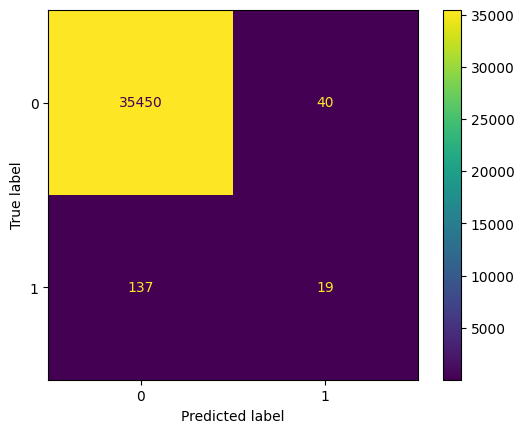

In [21]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

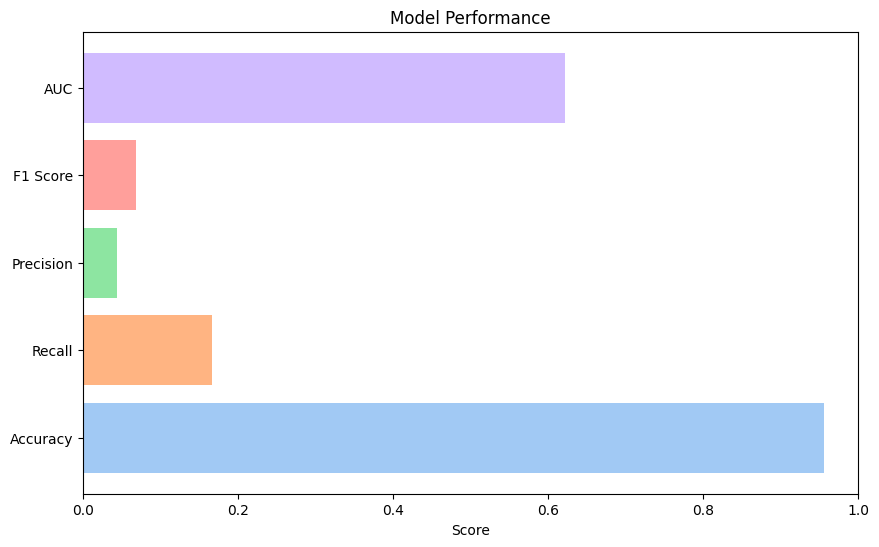

In [68]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [70]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                     feature  importance
1            DTDmedianNonFin        5268
19         price_to_earnings        2736
3                        sic        2503
20           retention_ratio        2122
7                 cash_ratio        1906
13    cashflow_to_debt_ratio        1628
14         net_profit_margin        1627
18  working_capital_turnover        1473
4                        atq        1451
15            asset_turnover        1420
8        net_working_capital        1395
16      receivables_turnover        1313
5              current_ratio        1308
6                quick_ratio        1305
10      debt_to_equity_ratio        1260
17     day_sales_outstanding        1218
12  financial_leverage_ratio        1204
11              equity_ratio        1143
9                 debt_ratio        1058
0               DTDmedianFin         662
2                dummy297fin           0


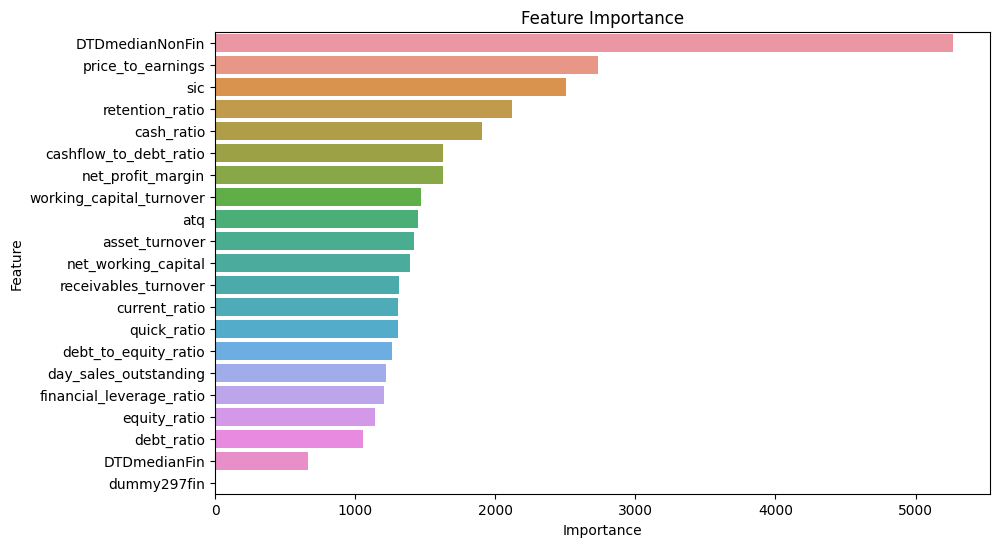

In [72]:
feature_importance = gbm.feature_importance()
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [ ]:
model = LGBMClassifier()
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
y_pred_binary = np.round(pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 463380, number of used features: 21
[LightGBM] [Info] Start training from score -0.007880
[LightGBM] [Info] Start training from score -4.850693
[LightGBM] [Info] Start training from score -10.561396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train_scaled,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test_scaled,y_test)))

Training accuracy 0.9921
Testing accuracy 0.9919


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115004
         1.0       0.28      0.07      0.11       839
         2.0       0.00      0.00      0.00         2

    accuracy                           0.99    115845
   macro avg       0.42      0.36      0.37    115845
weighted avg       0.99      0.99      0.99    115845



<font size="6">Testing LightGBM model with filled_table</font>

In [ ]:
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
credentials_path = 'data_cleaning/token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [ ]:
project_id = 'capstone-398012'
dataset_id = 'capstone'
table_id = "filled_table"

In [ ]:
from pandas_gbq import read_gbq

query = f"""
SELECT *
FROM `{project_id}.{dataset_id}.{table_id}`

"""

# Authenticate and read data from BigQuery into a DataFrame
df = read_gbq(query, project_id=project_id, dialect='standard')
df

/usr/local/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2155: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#drop na rows
test_df = df.dropna()
test_df

,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#map event type
test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)
test_df

/var/folders/rz/d40gjr2505ddk3wl3mnzmvdm0000gn/T/ipykernel_15768/3448417843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
X = test_df.drop(['Event_type', 'yyyy', 'mm', 'EventDate'], axis=1)  # Features
y = test_df['Event_type']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = {0:1, 1:100}
model = LGBMClassifier( class_weight = class_weights)
model.fit(X_train, y_train)
pred = model.predict(X_test)

[LightGBM] [Info] Number of positive: 727, number of negative: 9015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4108
[LightGBM] [Info] Number of data points in the train set: 9742, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.889678 -> initscore=2.087452
[LightGBM] [Info] Start training from score 2.087452


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.7540
Testing accuracy 0.6773


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80      2254
           1       0.14      0.67      0.24       182

    accuracy                           0.68      2436
   macro avg       0.55      0.67      0.52      2436
weighted avg       0.90      0.68      0.75      2436



push updated table to gbq, ie the table used for modeling

In [ ]:
new_df = df.dropna()
new_df = new_df.drop(['yyyy', 'mm', 'EventDate'], axis=1,)
new_df['Event_type'] = new_df['Event_type'].map(lambda x : 0 if x ==2  else x)
new_df

,CompNo,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,0.001367,0.666644,...,3,1,1,0,0,0,1,1,1,1
1,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
2,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
3,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
4,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12335,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12336,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12337,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
new_df.to_gbq(destination_table=f'{project_id}.{dataset_id}.filled_table', project_id=project_id, if_exists='replace')